In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime

import MetaTrader5 as mt5
import pytz

from IPython.display import display, display_markdown

### MT5を利用してEURJPYの日足データ(標準バー)を取得する(1994/01/01~2020/12/31)

In [2]:
# connect to MetaTrader 5
if not mt5.initialize():
    print("initialize() failed")
    mt5.shutdown()

# set time zone to UTC
timezone = pytz.utc

# create 'datetime' objects in UTC time zone to avoid the implementation of a local time zone offset
utc_from = datetime(1994, 1, 1, tzinfo=timezone)
utc_to = datetime(2021, 1, 1, tzinfo=timezone)
 
rates = mt5.copy_rates_range("EURJPY", mt5.TIMEFRAME_D1, utc_from, utc_to)
rates_frame = pd.DataFrame(rates)

# convert time in seconds into the datetime format
rates_frame['time']=pd.to_datetime(rates_frame['time'], unit='s')

# shut down connection to the MetaTrader 5 terminal
mt5.shutdown()

# display data
rates_frame.head(10)

,time,open,high,low,close,tick_volume,spread,real_volume
0,1994-01-03,125.85,126.70,125.78,126.36,1331,50,0
1,1994-01-04,126.28,127.50,126.28,126.80,1921,50,0
2,1994-01-05,126.88,127.89,126.49,127.05,2631,50,0
3,1994-01-06,127.09,127.28,126.14,126.23,1421,50,0
4,1994-01-07,126.34,126.74,125.72,126.71,1671,50,0
5,1994-01-10,126.57,127.06,126.27,126.60,1551,50,0
6,1994-01-11,126.68,127.00,126.05,126.07,1291,50,0
7,1994-01-12,126.03,126.83,125.96,126.55,1221,50,0
8,1994-01-13,126.55,127.00,124.68,124.94,3031,50,0
9,1994-01-14,124.97,125.13,123.51,124.00,2271,50,0


In [3]:
rates_frame.set_index('time', inplace=True)
rates_frame.index = pd.to_datetime(rates_frame.index)

## ラベリング

### CUSUMフィルター(ローリング指数荷重標準偏差)

In [4]:
def getDailyVol(close, span0=100):
    # 日次ボラティリティ, closeに従いインデックス再作成(不要)
    # df0 = (n+1日, n日)を作成しているだけ
    # df0 = close.index.searchsorted(close.index - pd.Timedelta(days=1))
    # df0 = df0[df0 > 0]
    # df0 = pd.Series(close.index[df0 - 1], index=close.index[close.shape[0] - df0.shape[0]:])
    
    # 日次リターン
    df0 = close.diff() / close
    df0 = df0.ewm(span=span0).std()
    
    df0.columns = ['vol']

    return df0.dropna()

In [5]:
close = rates_frame[['close']].copy()
vol = getDailyVol(close)

In [6]:
def getTEvents(gRaw:pd.Series, h):
    '''
    本書のサンプルコード
    '''
    tEvents, sPos, sNeg = [], 0, 0
    diff = gRaw.diff()
    for i in diff.index[1:]:
        sPos, sNeg = max(0, sPos + diff.loc[i]), min(0, sNeg + diff.loc[i])
        if sNeg < -h:
            sNeg = 0
            tEvents.append(i)
        elif sPos > h:
            sPos = 0
            tEvents.append(i)
    
    return pd.DatetimeIndex(tEvents)

In [7]:
tEvents = getTEvents(vol['vol'], 0.0005)
print(len(tEvents))

431


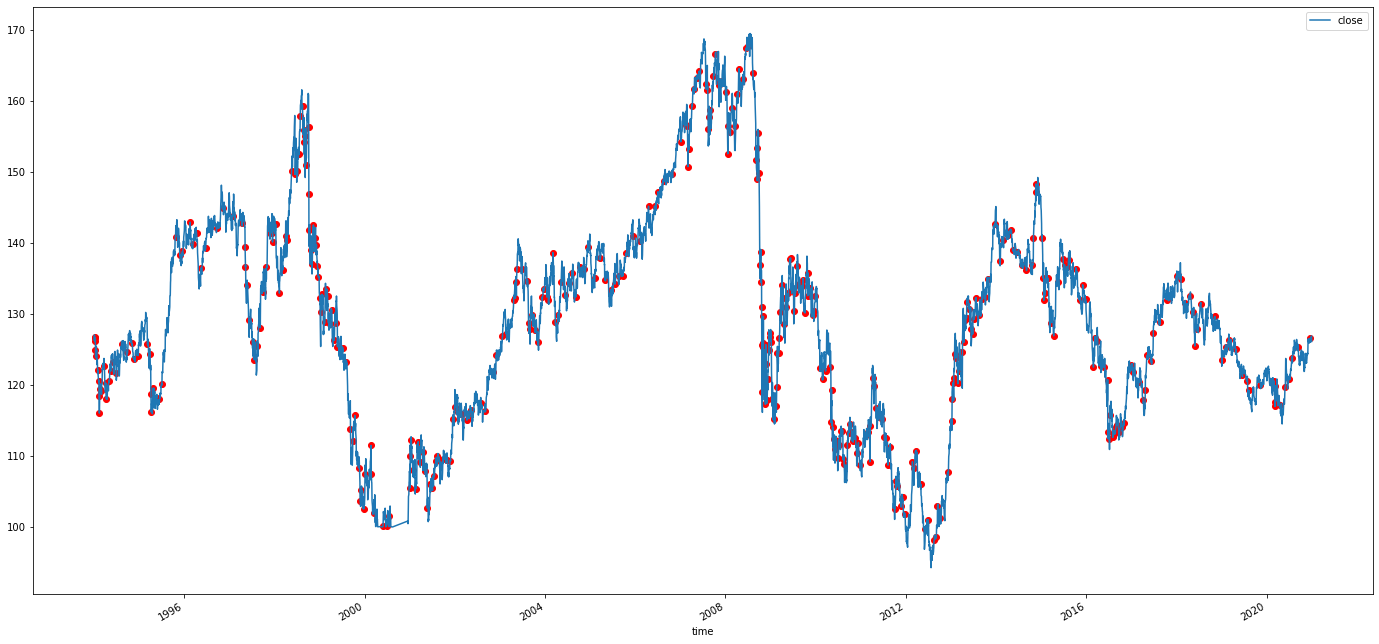

In [8]:
close.plot(figsize=(24, 12))
plt.scatter(x=tEvents, y=close.loc[tEvents], color='red')

### 垂直バリア:とりあえず10日?

In [9]:
numDays = 10
t1 = close.index.searchsorted(tEvents + pd.Timedelta(days=numDays))
t1 = t1[t1 < close.shape[0]]
t1 = pd.Series(close.index[t1], index=tEvents[:t1.shape[0]])
t1

1994-01-06   1994-01-17
1994-01-07   1994-01-17
1994-01-10   1994-01-20
1994-01-13   1994-01-24
1994-01-18   1994-01-28
                ...    
2020-05-29   2020-06-08
2020-07-02   2020-07-13
2020-07-27   2020-08-06
2020-09-10   2020-09-21
2020-12-18   2020-12-28
Name: time, Length: 431, dtype: datetime64[ns]

### 水平バリア: volの動的関数
ボラティリティが高いときは、水平バリア(損切, 利食い)もある程度許容するような関数とする。  
とりあえず、簡単のため3σにでもしておく。(利食い：損切=2:1)

<AxesSubplot:xlabel='time'>

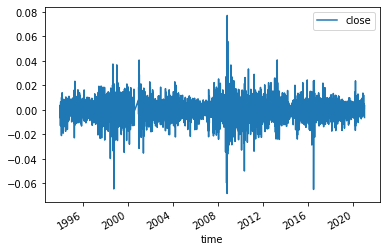

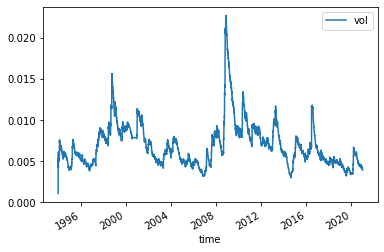

In [10]:
Return = close.diff() / close
Return.plot()
vol.plot()

### トリプルバリア法

In [11]:
events = pd.DataFrame(t1)
events.columns = ['t1']
events['trgt'] = vol['vol']
events.head()

,t1,trgt
1994-01-06,1994-01-17,0.005394
1994-01-07,1994-01-17,0.004870
1994-01-10,1994-01-20,0.004254
1994-01-13,1994-01-24,0.006125
1994-01-18,1994-01-28,0.005556


In [12]:
ptSl = [2, 1]
molecule = None

def applyPtSlOnT1(close, events, ptSl, molecule):
    # t1(イベント終了)前に行われた場合は、ストップロス/利食いを実施
    events_ = events #.loc[molecule]
    out = events_[['t1']].copy(deep=True)
    
    if ptSl[0] > 0:
        pt = ptSl[0] * events_['trgt']
    else:
        pd.Series(index=events.index)
    
    if ptSl[1] > 0:
        sl = -ptSl[1] * events_['trgt']
    else:
        pd.Series(index=events.index)
    
    for loc, t1 in events_['t1'].iteritems(): #(index, value)でiter
        df0 = close[loc:t1] # 価格経路
        df0 = (df0 / close.loc[loc] - 1) #* events_.at # リターン
        
        # ストップロスの最短タイミング
        out.loc[loc, 'sl'] = df0[df0.values < sl[loc]].index.min()
        # 利食いの最短タイミング
        out.loc[loc, 'pt'] = df0[df0.values > pt[loc]].index.min()
    
    return out

In [13]:
events = applyPtSlOnT1(close, events, ptSl, None)
events

,t1,sl,pt
1994-01-06,1994-01-17,1994-01-13,NaT
1994-01-07,1994-01-17,1994-01-11,NaT
1994-01-10,1994-01-20,1994-01-13,NaT
1994-01-13,1994-01-24,1994-01-14,NaT
1994-01-18,1994-01-28,1994-01-26,1994-01-20
...,...,...,...
2020-05-29,2020-06-08,NaT,2020-06-02
2020-07-02,2020-07-13,NaT,NaT
2020-07-27,2020-08-06,2020-07-28,2020-08-05
2020-09-10,2020-09-21,2020-09-16,NaT


### ラベル付け

#### 2クラス分類モデル

In [14]:
def getBins(events, close):
    #1) イベント発生時の価格
    events_ = events.dropna(subset=['t1'])
    px = events_.index.union(events_['t1'].values).drop_duplicates()
    px = close.reindex(px, method='bfill')
    
    #2) outオブジェクトの生成
    out = pd.DataFrame(index=events_.index)
    out['ret'] = px.loc[events_['t1'].values].values / px.loc[events_.index] - 1
    out['bin'] = np.sign(out['ret'])
    return out

In [15]:
labels = getBins(events, close)
labels.head()

,ret,bin
1994-01-06,-0.019092,-1.0
1994-01-07,-0.022808,-1.0
1994-01-10,-0.008847,-1.0
1994-01-13,-0.000640,-1.0
1994-01-18,-0.004432,-1.0


<AxesSubplot:>

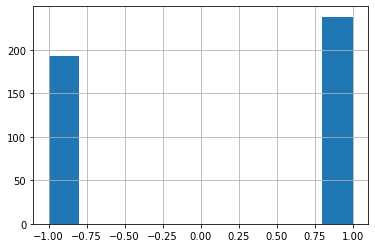

In [16]:
labels['bin'].hist()

#### 3クラス分類

In [17]:
def getBins_with0(events, close):
    #1) イベント発生時の価格
    events_ = events.dropna(subset=['t1'])
    px = events_.index.union(events_['t1'].values).drop_duplicates()
    px = close.reindex(px, method='bfill')
    
    #2) outオブジェクトの生成
    out = pd.DataFrame(index=events_.index)
    out['ret'] = px.loc[events_['t1'].values].values / px.loc[events_.index] - 1
    
    # 垂直バリアの場合は0
    out.at[events[events['sl'].isnull() & events['pt'].isnull()].index, :] = 0
    
    out['bin'] = np.sign(out['ret'])
    return out

<AxesSubplot:>

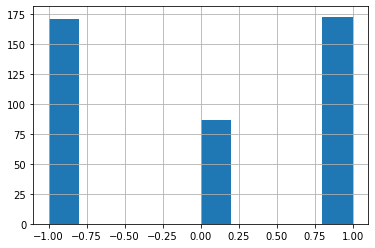

In [18]:
labels = getBins_with0(events, close)
labels['bin'].hist()

In [19]:
labels.head()

,ret,bin
1994-01-06,-0.019092,-1.0
1994-01-07,-0.022808,-1.0
1994-01-10,-0.008847,-1.0
1994-01-13,-0.000640,-1.0
1994-01-18,-0.004432,-1.0


### 一般的なテクニカル分析に基づくトレンドフォロー戦略

In [20]:
def get_position_by_GC(events, close, term=[5, 25]):
    '''
    ゴールデンクロスに基づく
    '''
    df_tech = close.copy()
    # MA計算
    df_tech[f'MA{term[0]}'] = close.rolling(term[0]).mean()
    df_tech[f'MA{term[1]}'] = close.rolling(term[1]).mean()
    df_tech.dropna(inplace=True)
    
    # 位置判定
    df_tech['position'] = (df_tech[f'MA{term[0]}'] > df_tech[f'MA{term[1]}']).astype(int)
    df_tech['position'].replace(0, -1, inplace=True)
    
    # 取り出すインデックスを指定
    index = events.index.intersection(df_tech.index)

    return df_tech.loc[index]

In [21]:
position_GC = get_position_by_GC(events, close)
position_GC.head()

,close,MA5,MA25,position
1994-02-08,120.57,121.262,123.9876,-1
1994-02-11,118.47,120.144,123.1684,-1
1994-02-14,116.04,119.224,122.7460,-1
1994-02-18,119.48,117.732,121.5884,-1
1994-02-25,119.18,119.574,120.5916,-1


In [22]:
strategy = pd.merge(labels, position_GC, left_index=True, right_index=True)
strategy.head()

,ret,bin,close,MA5,MA25,position
1994-02-08,-0.009040,-1.0,120.57,121.262,123.9876,-1
1994-02-11,0.014265,1.0,118.47,120.144,123.1684,-1
1994-02-14,0.028266,1.0,116.04,119.224,122.7460,-1
1994-02-18,0.000000,0.0,119.48,117.732,121.5884,-1
1994-02-25,0.000000,0.0,119.18,119.574,120.5916,-1


Text(0.5, 1.0, 'Total profit')

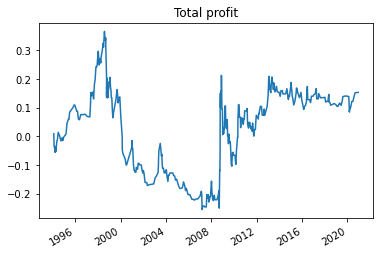

In [23]:
Total_profit = strategy['ret'] * strategy['position']

Total_profit.cumsum().plot()
plt.title('Total profit')

### ランダムフォレストによりトレードするかどうかを決定する
<利用する特徴量>
* ボラティリティ
* 移動平均のクロス

In [24]:
XY = pd.merge(strategy, vol, left_index=True, right_index=True)
XY.head()

,ret,bin,close,MA5,MA25,position,vol
1994-02-08,-0.009040,-1.0,120.57,121.262,123.9876,-1,0.005200
1994-02-11,0.014265,1.0,118.47,120.144,123.1684,-1,0.005980
1994-02-14,0.028266,1.0,116.04,119.224,122.7460,-1,0.006997
1994-02-18,0.000000,0.0,119.48,117.732,121.5884,-1,0.007581
1994-02-25,0.000000,0.0,119.18,119.574,120.5916,-1,0.007025


In [25]:
len_dataset = len(XY)
train_size = int(len_dataset * 0.8)
test_size = len_dataset - train_size
print(len_dataset, train_size, test_size)

train = XY.iloc[:train_size, :]
test = XY.iloc[train_size:, :]

425 340 85


In [26]:
print(numDays)
display(train.tail())
display(test.head())

10


,ret,bin,close,MA5,MA25,position,vol
2013-08-15,0.013632,1.0,129.840,129.5032,130.44192,-1,0.007750
2013-09-13,0.009221,1.0,132.085,132.5300,130.98492,1,0.007198
2013-10-03,0.009982,1.0,132.437,132.5796,132.39632,1,0.006667
2013-10-29,-0.019082,-1.0,134.942,134.4718,133.28292,1,0.006117
2013-12-24,-0.001234,-1.0,142.602,142.4912,140.08224,1,0.005795


,ret,bin,close,MA5,MA25,position,vol
2014-01-31,0.014356,1.0,137.499,139.5720,141.79968,-1,0.006148
2014-02-25,0.019782,1.0,140.481,140.5954,139.68596,1,0.005648
2014-04-11,0.000000,0.0,141.103,141.0828,141.62780,-1,0.005440
2014-04-29,-0.011547,-1.0,141.770,141.6378,141.47960,1,0.004910
2014-05-22,0.000000,0.0,138.952,138.9300,140.73264,-1,0.004379


リークの問題はなさそう

In [27]:
X_labels = ['position', 'vol']
Y_label = ['bin']

train_X, train_Y = train[X_labels], train[Y_label].replace(-1, 1)
test_X, test_Y = test[X_labels], test[Y_label].replace(-1, 1)

In [28]:
from sklearn.ensemble import RandomForestClassifier

In [29]:
clf = RandomForestClassifier(random_state=0)
clf.fit(train_X, train_Y.values.ravel())
pred_y = clf.predict(test_X)

print("score=", clf.score(test_X, test_Y))

score= 0.6235294117647059


In [30]:
result = test.copy()
result['bin'] = result['bin'].replace(-1, 1) 
result['pred_invest'] = pred_y
result.head()

,ret,bin,close,MA5,MA25,position,vol,pred_invest
2014-01-31,0.014356,1.0,137.499,139.5720,141.79968,-1,0.006148,1.0
2014-02-25,0.019782,1.0,140.481,140.5954,139.68596,1,0.005648,1.0
2014-04-11,0.000000,0.0,141.103,141.0828,141.62780,-1,0.005440,1.0
2014-04-29,-0.011547,1.0,141.770,141.6378,141.47960,1,0.004910,1.0
2014-05-22,0.000000,0.0,138.952,138.9300,140.73264,-1,0.004379,1.0


In [31]:
Total_Return_test1 = result['ret'] * result['position']
Total_Return_test2 = result['ret'] * result['position'] * result['pred_invest']

Text(0.5, 1.0, 'Techinical Strategy × RandomForest')

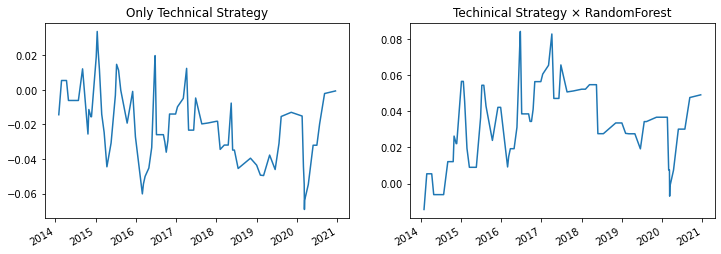

In [38]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
Total_Return_test1.cumsum().plot()
plt.title('Only Technical Strategy')

plt.subplot(1, 2, 2)
Total_Return_test2.cumsum().plot()
plt.title('Techinical Strategy × RandomForest')